In [2]:
from torch_geometric.data import HeteroData, DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, to_hetero , SAGEConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

import torch
from torch import nn 
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder , label_binarize , OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore") 

In [32]:
# *****************************************************************************
# Load the Dataframes :
path_work = "/media/concha-eloko/Linux/PPT_clean"
#path_work = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"

    # Open the DF
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df.tsv", sep = "\t" ,  header = 0)
DF_info = DF_info[DF_info["KL_type_LCA"].apply(lambda x: x.count("|")) < 2]

In [33]:
DF_info

,Phage,Protein_name,KL_type_LCA,Infected_ancestor,index,Dataset,seq,domain_seq,1,2,...,1272,1273,1274,1275,1276,1277,1278,1279,1280,prophage_id
0,GCF_016651625.1__phage29,GCF_016651625.1__phage29__142,KL43,GCF_016651625.1,ppt__1,ppt,MSVPNQTPYNIYTANGLTTVFTYEFYIISASDLRVSINGDVVTSGY...,KDFVNINDYWFPTDGDDFYPALNKALSVSPHVLIPPGKHYLKSTVS...,-0.018416,0.022387,...,0.004437,0.087907,0.015800,0.025778,0.065790,0.034045,-0.070899,0.016068,0.065339,prophage_12186
1,GCF_016651625.1__phage29,GCF_016651625.1__phage29__150,KL43,GCF_016651625.1,anubis__0,anubis,MRANLIKTNFTAGEISPRLMGRVDIARYANGAKIIENAVCVVQGGV...,QAASPGAWTREDTVWTEEFGYPGAVTLYQQRLVLAGSPQYPQTIWW...,0.036016,0.005938,...,-0.037612,0.008772,0.010556,-0.049738,-0.012549,0.092624,-0.136602,-0.191378,0.135658,prophage_12186
2,GCF_016651625.1__phage12,GCF_016651625.1__phage12__59,KL43,GCF_016651625.1,ppt__4,ppt,MSISKRNFLKAVSCAYFFYSFKALTKVNQPIEDYISTKDKNTWPSK...,NTWPSKVHRVEEFYTSTDRDYSDAILRGINYCSLNNCVLFFSDKYK...,0.026004,0.024372,...,-0.026018,0.018206,0.036751,-0.032549,0.064112,0.061520,-0.024423,-0.027998,0.028089,prophage_924
3,GCF_019928025.1__phage0,GCF_019928025.1__phage0__10,KL43,n1471,ppt__4,ppt,MSISKRNFLKAVSCAYFFYSFKALTKVNQPIEDYISTKDKNTWPSK...,NTWPSKVHRVEEFYTSTDRDYSDAILRGINYCSLNNCVLFFSDKYK...,0.026004,0.024372,...,-0.026018,0.018206,0.036751,-0.032549,0.064112,0.061520,-0.024423,-0.027998,0.028089,prophage_2929
4,GCF_004313505.1__phage4,GCF_004313505.1__phage4__113,KL14,GCF_004313505.1,anubis__5,anubis,MSEYDTGNPVPSASMPDAWDNMQSIDKFVNSSDETITTRTGQQLDT...,KAIFDAWLDFGIDWNGNESISLQLQTAVNYVSKLPYGGEIVLRPGV...,-0.023648,0.052674,...,-0.025991,0.068538,-0.051192,0.026481,0.069100,0.017813,-0.103797,0.018961,0.117058,prophage_11091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20134,GCF_002248635.1__phage4,GCF_002248635.1__phage4__44,KL102,n320,anubis_return__4264,anubis_return,MVSLKGMGSTFRDCTALISLPSGLLDGCINLTSLTLTFSGCTSLAL...,MVSLKGMGSTFRDCTALISLPSGLLDGCINLTSLTLTFSGCTSLAL...,-0.000585,-0.087093,...,0.036749,0.048489,0.020484,0.023950,-0.048109,0.134457,-0.101326,0.088485,0.037368,prophage_3054
20135,GCF_001905235.1__phage21,GCF_001905235.1__phage21__0,KL107,n35403540,anubis_return__4272,anubis_return,MLKHSLAIATCLAFSSSVMGNEANLLYTNTMQFPYKHNADGYMVFD...,VMGNEANLLYTNTMQFPYKHNADGYMVFDIHGKLVVPPEGHFDTLN...,0.076721,0.027635,...,0.042391,-0.004292,-0.004047,-0.011631,-0.026469,0.070159,-0.077212,-0.077950,-0.034630,prophage_313
20136,GCF_004312845.1__phage3,GCF_004312845.1__phage3__38,KL9,GCF_004312845.1,anubis_return__4275,anubis_return,MAILITGKSMTRLPESSSWEEEIELITRSERVAGGLDGPANRPLKS...,DAVIRRDLASDKGTSGVGKLGDKPLVAISYYKSKGQSDQDAVQAAF...,0.032196,0.048856,...,-0.016331,0.084711,0.056063,0.001793,0.073958,0.090169,-0.060105,0.023726,0.086452,prophage_12656
20137,GCF_900172635.1__phage2,GCF_900172635.1__phage2__1608,KL124,GCF_900172635.1,anubis_return__4287,anubis_return,MADLSISVISDQASESNQAGWWHPLDSFQGVEYYGLCKEYGTAGYH...,MADLSISVISDQASESNQAGWWHPLDSFQGVEYYGLCKEYGTAGYH...,-0.011089,-0.005328,...,0.034656,0.046130,0.012586,-0.021702,-0.023386,0.105700,-0.099147,-0.057367,0.091427,prophage_12780


> Mean number of dpos per prophage :

In [6]:
numbers_dpos = []

for phage in tqdm(DF_info["Phage"].unique()) : 
    df_phage = DF_info[DF_info["Phage"] == phage]["index"]
    n_dpos = len(df_phage)
    numbers_dpos.append(n_dpos)


100%|█████████████████████████████████████████████████████████████████████████████████| 15788/15788 [00:21<00:00, 721.17it/s]


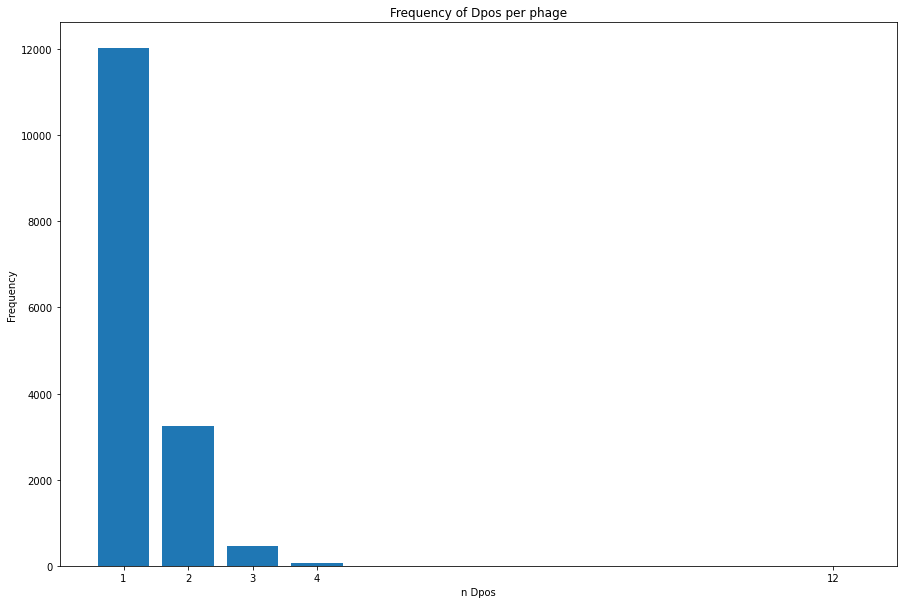

In [16]:
import matplotlib.pyplot as plt
counter = Counter(numbers_dpos)

# Prepare data for plotting
labels, values = zip(*counter.items())
plt.figure(figsize=(15, 10))

plt.bar(labels, values, tick_label=labels)
plt.title('Frequency of Dpos per phage')
plt.xlabel('n Dpos')
plt.ylabel('Frequency')

plt.show()

> Per Dpos, how many different KLtypes : 

In [12]:
associated_KLtypes = []

for dpo in tqdm(DF_info["index"].unique()) : 
    df_dpo = DF_info[DF_info["index"] == dpo]["KL_type_LCA"].unique()
    n_kltypes = len(df_dpo)
    associated_KLtypes.append(n_kltypes)


100%|███████████████████████████████████████████████████████████████████████████████████| 4247/4247 [00:05<00:00, 765.05it/s]


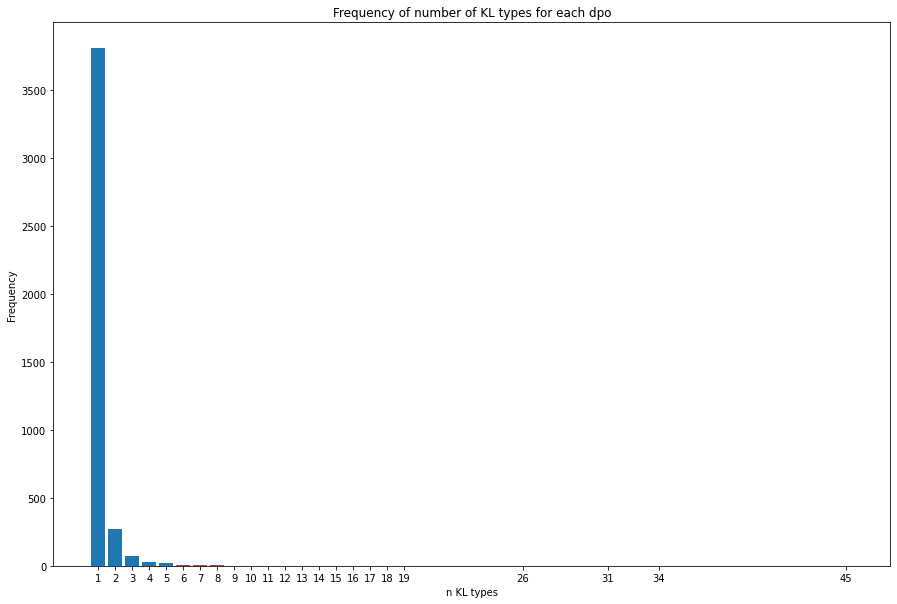

In [15]:
counter = Counter(associated_KLtypes)

# Prepare data for plotting
labels, values = zip(*counter.items())
plt.figure(figsize=(15, 10))
plt.bar(labels, values, tick_label=labels)
plt.title('Frequency of number of KL types for each dpo')
plt.xlabel('n KL types')
plt.ylabel('Frequency')

plt.show()

***
# T-SNE representation of the Dpo embeddings : 

In [34]:
DF_info_tsne = DF_info.drop_duplicates(subset = ["KL_type_LCA", "index"])

In [35]:
DF_info_tsne["nuevo_index"] = DF_info_tsne["index"] + "___" + DF_info_tsne["KL_type_LCA"]


0                      ppt__1___KL43
1                   anubis__0___KL43
2                      ppt__4___KL43
4                   anubis__5___KL14
5                   anubis__7___KL14
                    ...             
20134    anubis_return__4264___KL102
20135    anubis_return__4272___KL107
20136      anubis_return__4275___KL9
20137    anubis_return__4287___KL124
20138     anubis_return__4305___KL63
Name: nuevo_index, Length: 5022, dtype: object

In [36]:
embedded_col = [str(n) for n in list(range(1,1281))]
df_embeddings = DF_info_tsne[embedded_col]

In [37]:
df_embeddings["index"] = DF_info_tsne["nuevo_index"]
df_embeddings.set_index("index", inplace = True)

In [38]:
df_embeddings

,1,2,3,4,5,6,7,8,9,10,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
index,,,,,,,,,,,,,,,,,,,,,
ppt__1___KL43,-0.018416,0.022387,0.002399,-0.017278,-0.087826,0.021351,0.027942,-0.098224,0.030447,0.034909,...,0.030484,0.004437,0.087907,0.015800,0.025778,0.065790,0.034045,-0.070899,0.016068,0.065339
anubis__0___KL43,0.036016,0.005938,-0.043535,0.008279,-0.123777,0.036835,0.069866,-0.223139,0.025767,-0.031355,...,0.008465,-0.037612,0.008772,0.010556,-0.049738,-0.012549,0.092624,-0.136602,-0.191378,0.135658
ppt__4___KL43,0.026004,0.024372,-0.000237,0.007180,-0.097511,0.028741,0.002062,-0.077674,-0.000671,0.057368,...,0.054964,-0.026018,0.018206,0.036751,-0.032549,0.064112,0.061520,-0.024423,-0.027998,0.028089
anubis__5___KL14,-0.023648,0.052674,0.013845,-0.054170,-0.042814,0.001515,0.029037,-0.089098,0.076472,0.031100,...,-0.003019,-0.025991,0.068538,-0.051192,0.026481,0.069100,0.017813,-0.103797,0.018961,0.117058
anubis__7___KL14,-0.028778,0.060945,0.014562,-0.062623,-0.041045,-0.000214,0.030862,-0.087139,0.081545,0.028506,...,-0.004240,-0.020966,0.073692,-0.047220,0.027809,0.073462,0.025343,-0.100966,0.013383,0.116881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
anubis_return__4264___KL102,-0.000585,-0.087093,0.001573,0.063216,-0.086292,0.004700,0.110823,-0.127089,0.004283,0.070867,...,0.087606,0.036749,0.048489,0.020484,0.023950,-0.048109,0.134457,-0.101326,0.088485,0.037368
anubis_return__4272___KL107,0.076721,0.027635,0.014001,-0.024052,-0.053697,-0.025757,0.022476,-0.046226,-0.016443,0.015292,...,0.126354,0.042391,-0.004292,-0.004047,-0.011631,-0.026469,0.070159,-0.077212,-0.077950,-0.034630
anubis_return__4275___KL9,0.032196,0.048856,-0.017520,-0.048653,-0.075183,0.013526,-0.035467,-0.102460,0.021035,0.021758,...,0.004865,-0.016331,0.084711,0.056063,0.001793,0.073958,0.090169,-0.060105,0.023726,0.086452


In [39]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(df_embeddings)

df_2d = pd.DataFrame(embeddings_2d, columns=['x', 'y'], index=df_embeddings.index)
df_2d['label'] = [i.split("___")[1] for i in df_embeddings.index]


In [51]:
mask = df_2d["label"].apply(lambda x: count_kltypes[x] > 100)
df_preval = df_2d[mask]

c

,x,y,label
index,,,
anubis__5___KL14,43.874481,29.812370,KL14
anubis__7___KL14,41.037014,27.619989,KL14
ppt__21___KL107,63.311184,-8.018773,KL107
ppt__21___KL106,63.311184,-8.018773,KL106
ppt__21___KL23,63.510986,-8.370762,KL23
...,...,...,...
anubis_return__4151___KL27,38.591576,-11.510249,KL27
anubis_return__4161___KL28,-46.041435,37.311573,KL28
anubis_return__4206___KL28,-45.221870,35.397556,KL28


In [46]:
count_kltypes = dict(Counter(df_2d["label"]))
count_kltypes

{'KL43': 55,
 'KL14': 126,
 'KL107': 192,
 'KL106': 111,
 'KL23': 115,
 'KL51': 39,
 'KL63': 61,
 'KL122|KL106': 6,
 'KL30': 69,
 'KL64': 248,
 'KL47': 114,
 'KL36': 46,
 'KL15': 91,
 'KL31|KL47': 8,
 'KL105': 72,
 'KL103': 11,
 'KL111': 75,
 'KL24': 154,
 'KL19': 57,
 'KL21': 45,
 'KL27': 106,
 'KL2': 124,
 'KL102|KL108': 5,
 'KL38': 74,
 'KL28': 114,
 'KL52': 37,
 'KL108': 11,
 'KL155': 15,
 'KL112': 19,
 'KL46': 76,
 'KL102': 153,
 'KL1': 41,
 'KL17': 153,
 'KL151': 23,
 'KL22': 56,
 'KL8': 21,
 'KL16': 21,
 'KL3': 110,
 'KL110': 57,
 'KL25': 183,
 'KL163': 5,
 'KL10': 77,
 'KL48': 22,
 'KL57': 47,
 'KL45': 50,
 'KL58': 8,
 'KL132': 3,
 'KL113': 4,
 'KL127': 46,
 'KL122': 31,
 'KL142': 18,
 'KL62': 108,
 'KL66': 11,
 'KL7': 35,
 'KL20': 19,
 'KL114': 19,
 'KL169': 27,
 'KL28|KL60': 1,
 'KL153': 18,
 'KL60': 104,
 'KL12': 49,
 'KL158|KL62': 1,
 'KL55': 19,
 'KL125': 27,
 'KL74': 84,
 'KL35|KL155': 2,
 'KL149': 48,
 'KL64|KL111': 4,
 'KL39': 20,
 'KL60|KL25': 5,
 'KL81': 47,
 'KL128':

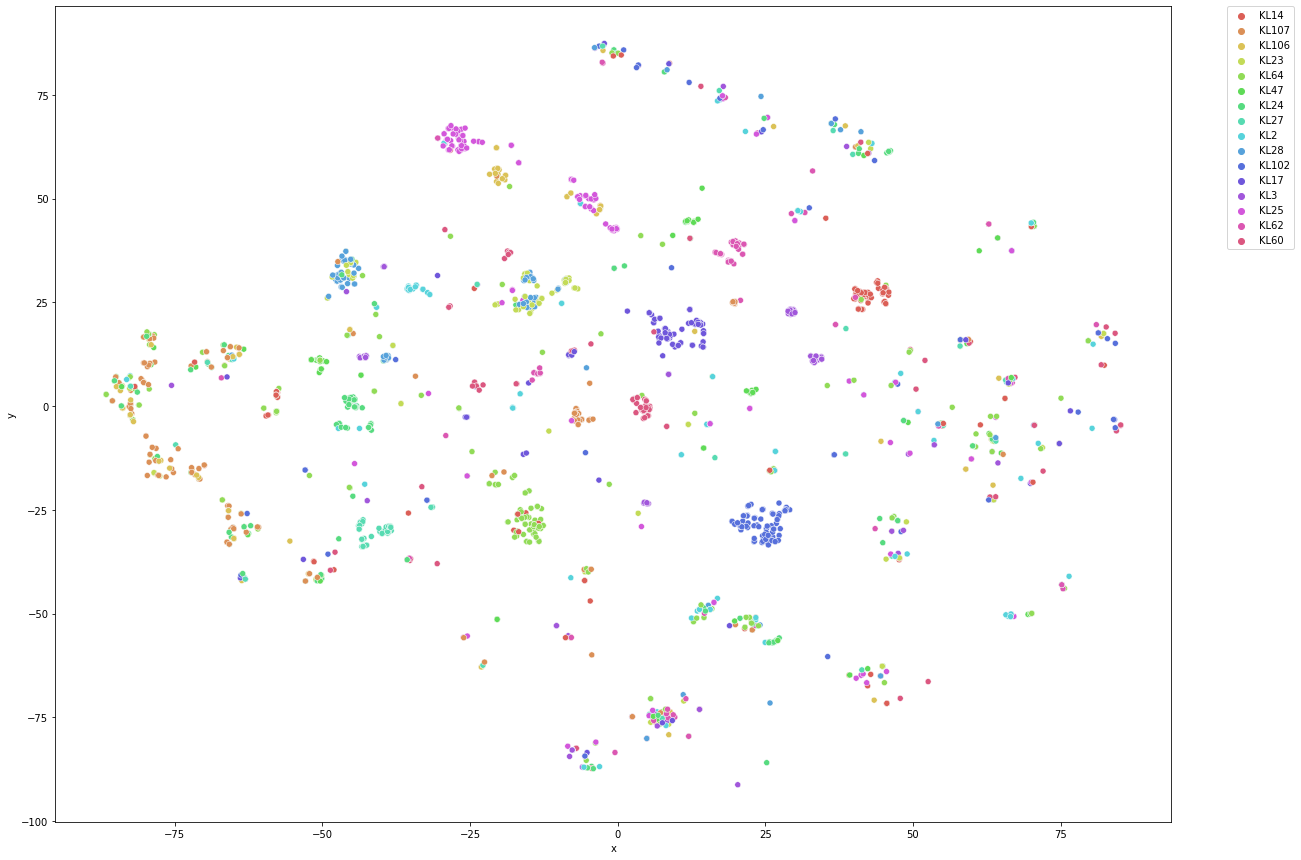

In [53]:
# Generate colors based on labels
df_plot = df_preval
palette = sns.color_palette("hls", len(df_plot['label'].unique()))

# Plot the t-SNE representation with labels
plt.figure(figsize=(20, 15))
sns.scatterplot(data=df_plot, 
                x='x', y='y', hue='label', legend='full', palette=palette)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('tsne_FOLDS.phagedepodetection.svg', format='svg', bbox_inches='tight', dpi = 500)
plt.show()